# NeuralProphet: A Neural-Network based Time-Series Library

In [1]:
from IPython import display
# display.Image("https://www.ealizadeh.com/wp-content/uploads/2020/11/BP05_featured_image.png")

**Website: https://ealizadeh.com**

**Medium: https://medium.com/@ealizadeh**

Copyright © 2020 Esmaeil Alizadeh

---

[NeuralProphet](https://github.com/ourownstory/neural_prophet) is a python library for modeling time-series data based on neural networks. It's built on top of [PyTorch](https://pytorch.org/) and is heavily inspired by [Facebook Prophet](https://github.com/facebook/prophet) and [AR-Net](https://github.com/ourownstory/AR-Net) libraries. 

## NeuralProphet Library

### NeuralProphet vs. Prophet

From the library name, you may ask what is the main difference between Facebook's Prophet library and NeuralProphet. According to NeuralProphet's [documentation](https://ourownstory.github.io/neural_prophet/changes-from-prophet/), the added features are[1]:
- Using PyTorch's Gradient Descent optimization engine making the modeling process much faster than Prophet
- Using AR-Net for modeling time-series autocorrelation (aka serial correlation)
- Custom losses and metrics
- Having configurable non-linear layers of feed-forward neural networks,
- etc.

### Project Maintainers
Based on the project's GitHub page, the main maintainer of this project is [Oskar Triebe](https://github.com/ourownstory) from Stanford University with collaboration from Facebook and Monash University. 

### Installation
The project is in the beta phase, so I would advise you to be cautious if you want to use this library in a production environment. 

Unfortunately, there is no pip or conda package for this library at the time of writing this article. You can install it by cloning the repository and installing it running `pip install .`. However, if you are going to use the package in a Jupyter Notebook environment, you should install their live version `pip install .[live]`. This will provide more features such as a live plot of train and validation loss using `plot_live_loss()`. 
```
git clone https://github.com/ourownstory/neural_prophet
cd neural_prophet
pip install .[live]
```

I would recommend creating a fresh environment (a conda or venv) and installing the NeuralProphet package from the new environment letting the installer take care of all dependencies (it has Pandas, Jupyter Notebook, PyTorch as dependencies).

Now that we have the package installed, let's play!

### Implementation with a Case Study
Here, I'm using the daily climate data in Delhi from 2013 to 2017 that I found on [Kaggle](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data). First, let's import the main packages.

In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
savefig_options = dict(format="png", bbox_inches="tight")

from neuralprophet import NeuralProphet

Then, we can read the data into a Panda DataFrame. NeuralProphet object expects the time-series data to have a date column named `ds` and the time-series column value we want to predict as `y`.

In [3]:
# Data is from https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data
df = pd.read_csv("./DailyDelhiClimateTrain.csv", parse_dates=["date"])
df = df[["date", "meantemp"]]
df.rename(columns={"date": "ds", "meantemp": "y"}, inplace=True)

Now let's initialize the model. Below, I've brought all default arguments defined for the NeuralProphet object, including additional information about some. These are the hyperparameters you can configure in the model. Of course, if you are planning to use the default variables, you can just do `model = NeuralProphet()`. 

In [4]:
model = NeuralProphet(
        growth="linear",
        changepoints=None,
        n_changepoints=5,
        changepoints_range=0.8,
        trend_reg=0,
        trend_reg_threshold=False,
        yearly_seasonality="auto",
        weekly_seasonality="auto",
        daily_seasonality="auto",
        seasonality_mode="additive",
        seasonality_reg=0,
        n_forecasts=1,
        n_lags=0,
        num_hidden_layers=0,
        d_hidden=None,
        ar_sparsity=None,
        learning_rate=None,
        epochs=40,
        loss_func="Huber",
        normalize="auto",
        impute_missing=True,
        log_level=None,  
)

After configuring the model and its hyperparameters, we need to train the model and make predictions. Let's make up to a one-year prediction of the temperature.

In [5]:
metrics = model.fit(df, validate_each_epoch=True, freq="D")
future = model.make_future_dataframe(df, periods=365, n_historic_predictions=len(df))
forecast = model.predict(future)

INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-01
Epoch[40/40]: 100%|██████████| 40/40 [00:02<00:00, 14.67it/s, SmoothL1Loss=0.00187, MAE=1.64, RegLoss=0, MAE_val=1.58, SmoothL1Loss_val=0.00191]


In [6]:
future = model.make_future_dataframe(df, periods=365, n_historic_predictions=len(df))
forecast = model.predict(future)

The one-year forecast plot is shown below (you can simply plot the forecast by calling `model.plot(forecast)`), where the time period between 2017-01-01 to 2018-01-01 is the prediction. As can be seen, the forecast plot resembles the historical time-series. It both captured the seasonality as well as the slow-growing linear trend. 

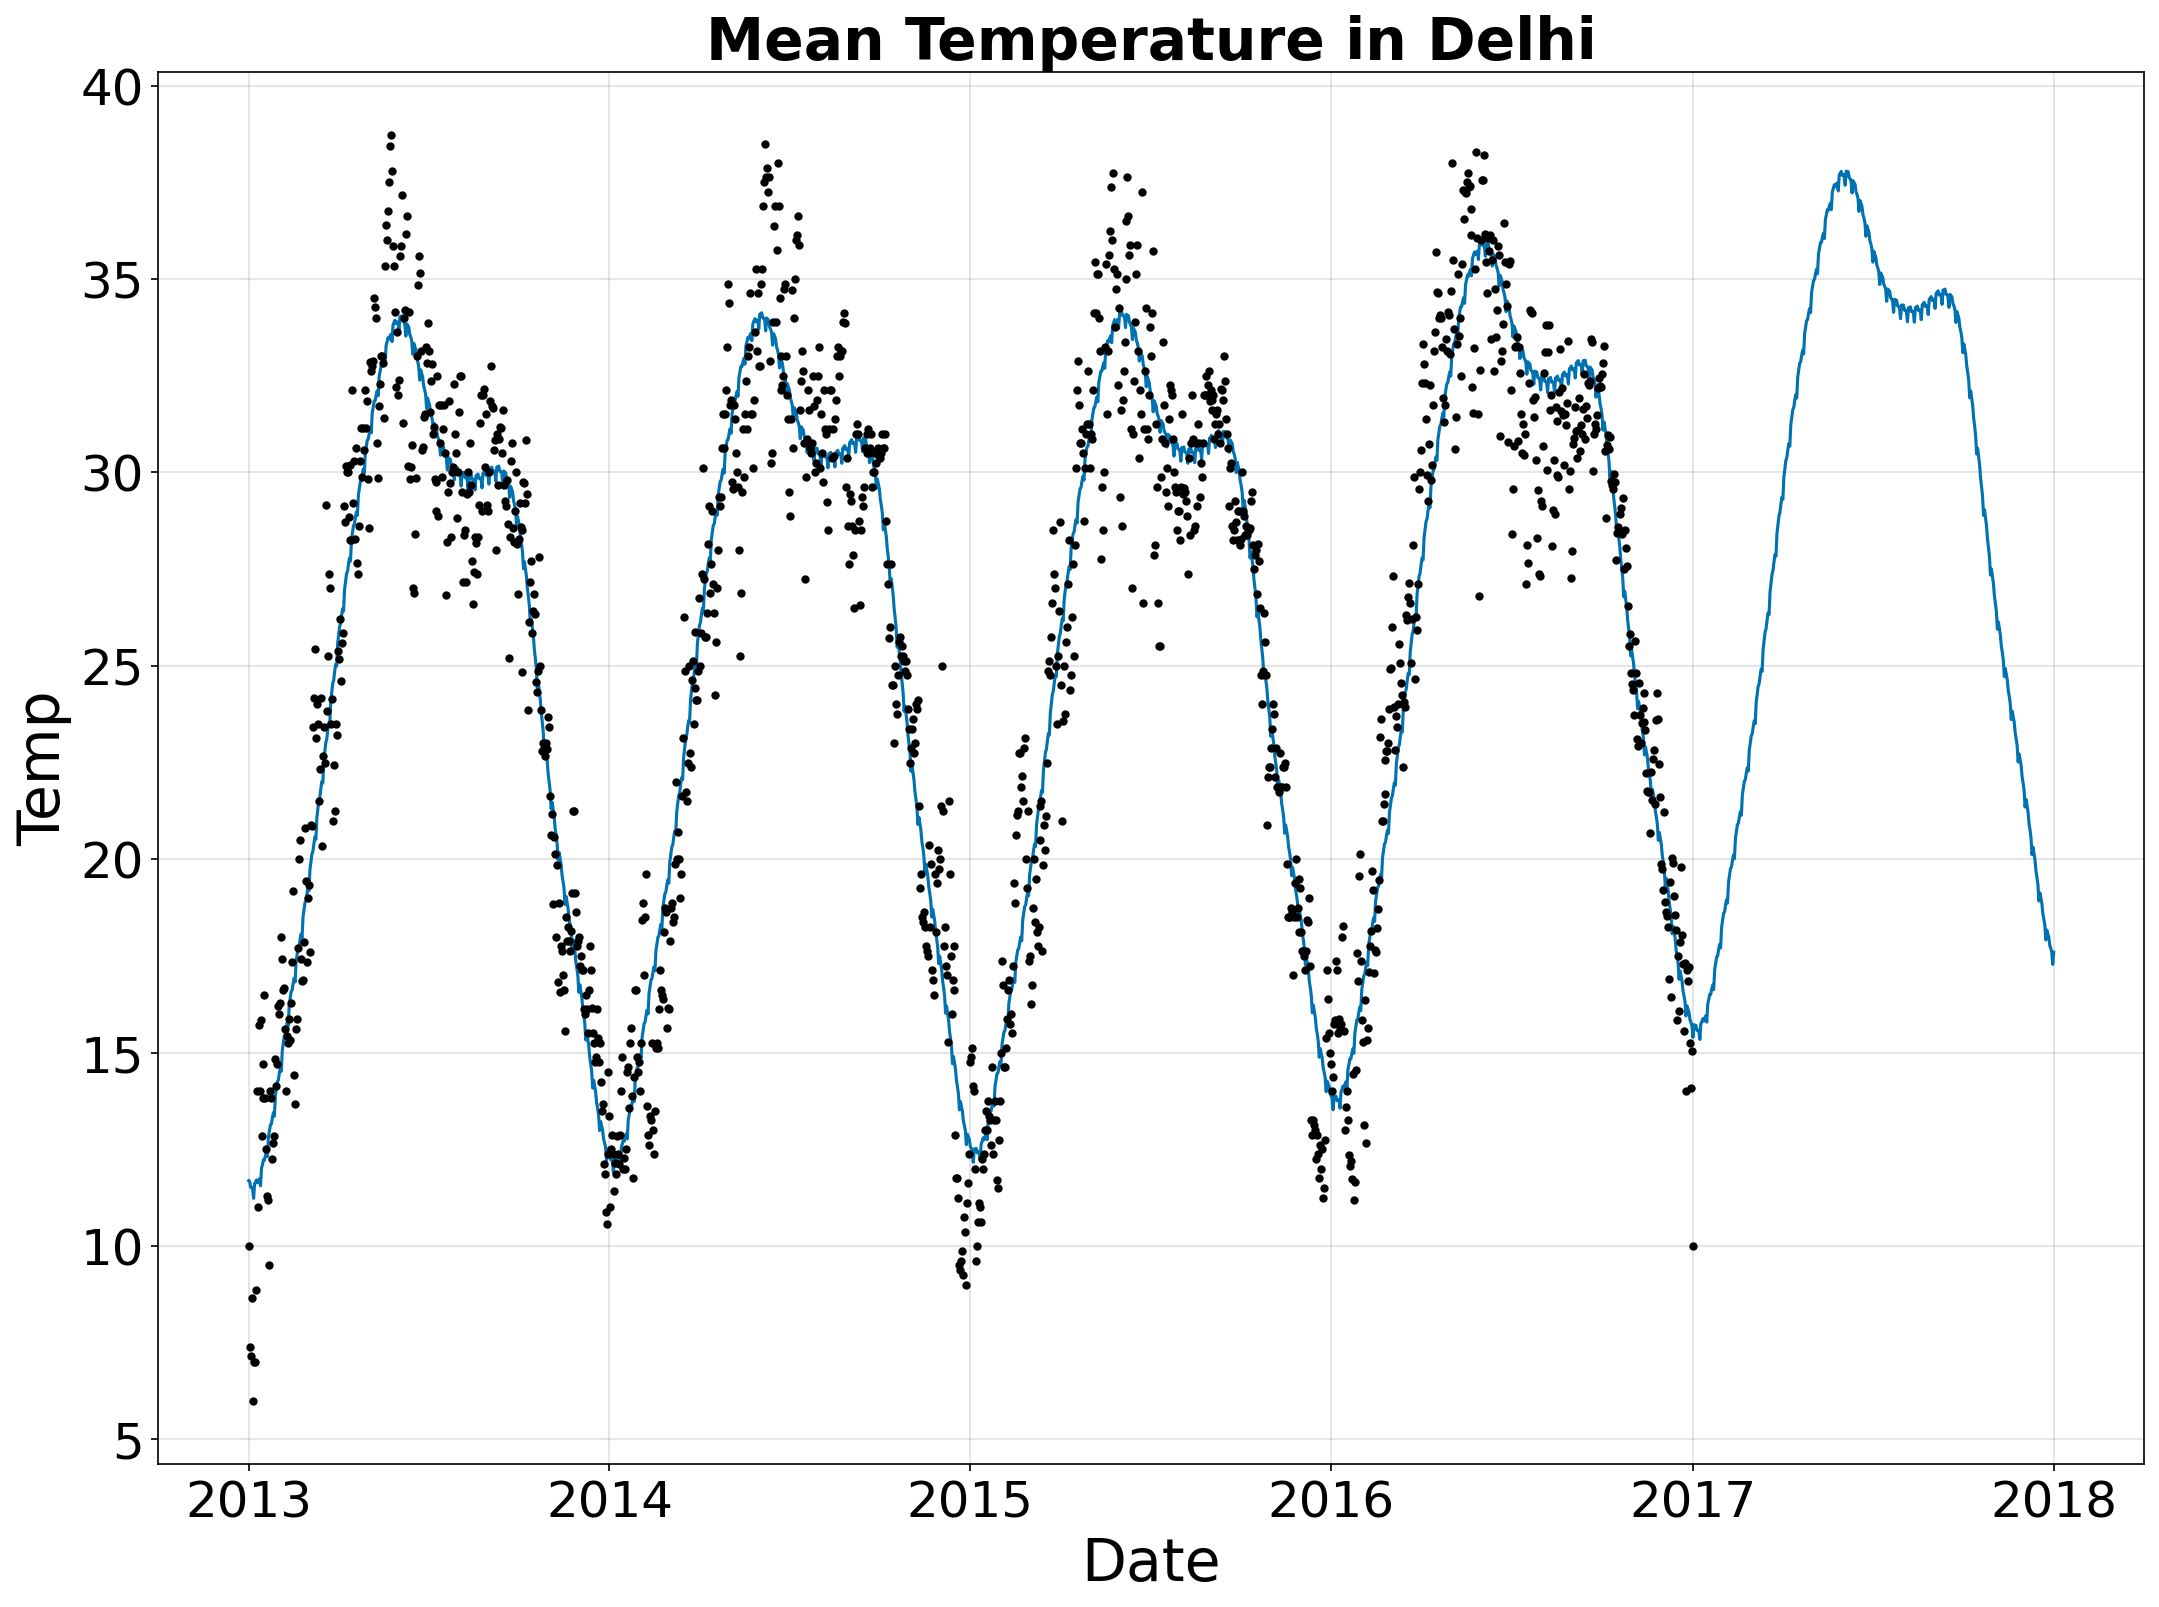

In [7]:
fig, ax = plt.subplots(figsize=(14, 10))
model.plot(forecast, xlabel="Date", ylabel="Temp", ax=ax)

ax.xaxis.label.set_size(28)
ax.yaxis.label.set_size(28)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_title("Mean Temperature in Delhi", fontsize=28, fontweight="bold")

fig.savefig("mean_temp_delhi_forecast.png", **savefig_options)

You can plot the parameters by calling `model.plot_parameters()`

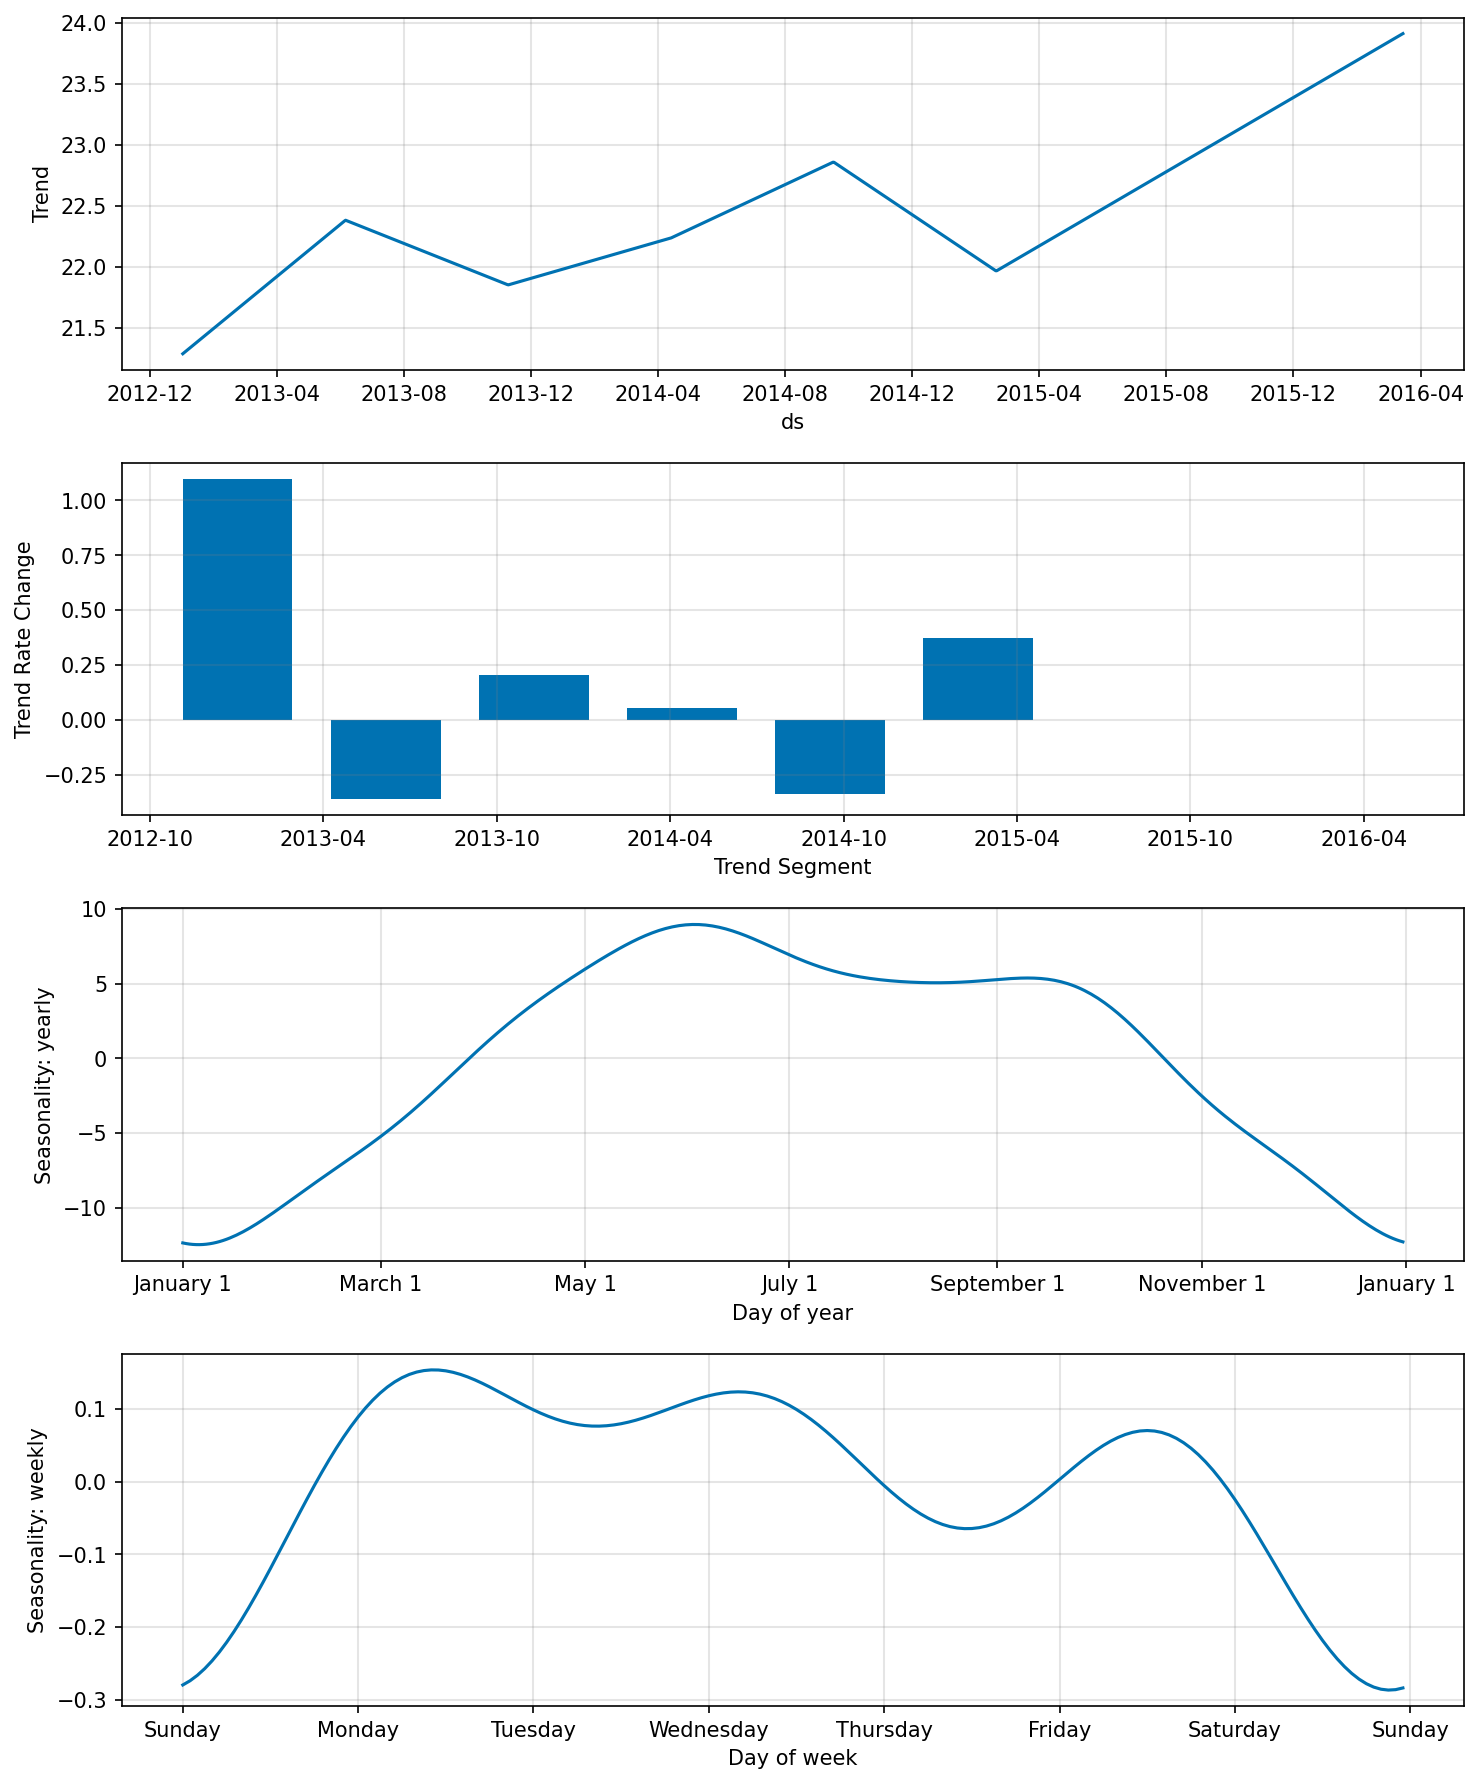

In [8]:
fig_param = model.plot_parameters()
fig_param.savefig("parameters.png", **savefig_options)

The model loss using Mean Absolute Error (MAE) is plotted below. You can also use the Smoothed L1-Loss function. 

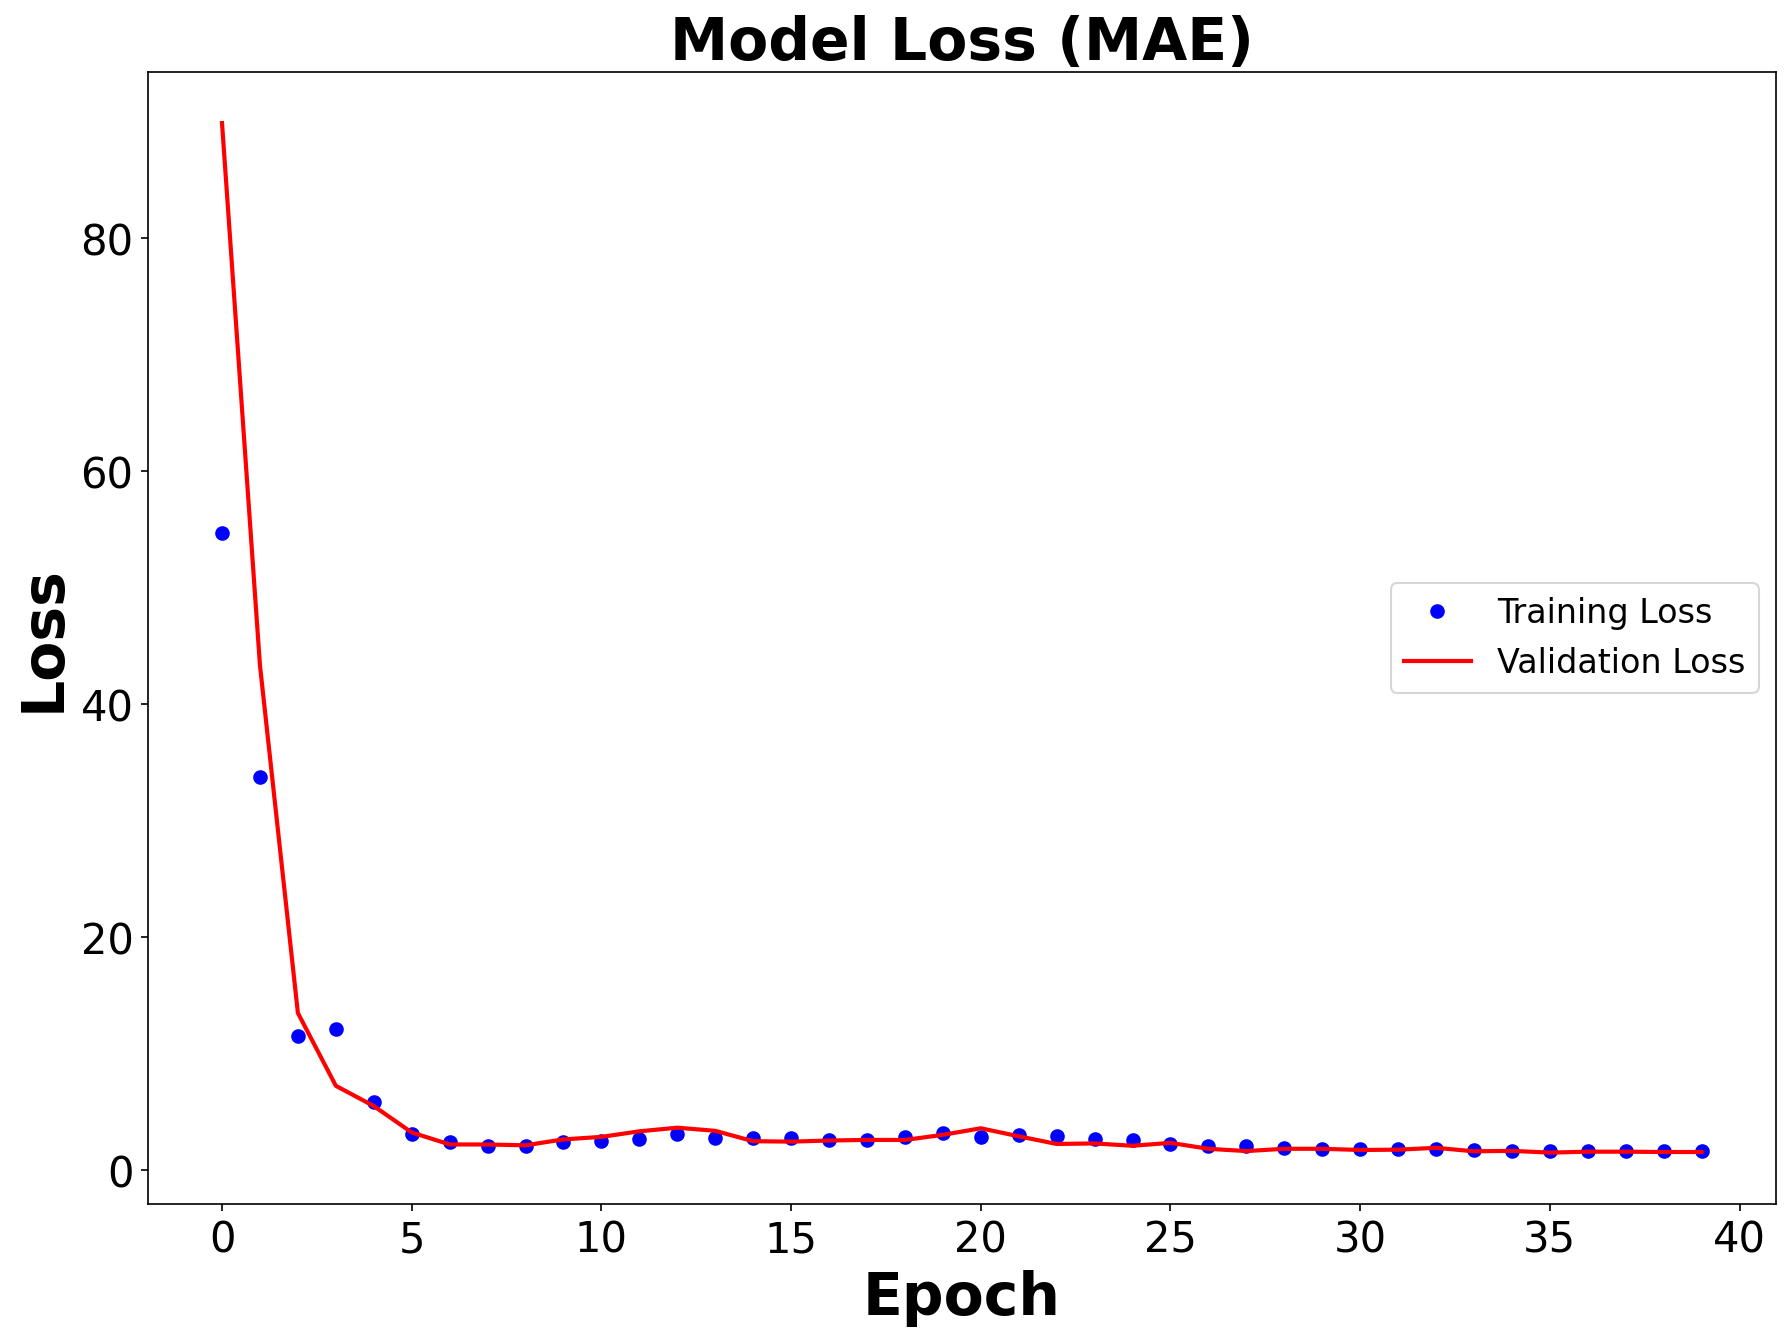

In [9]:
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(metrics["MAE"], 'ob', linewidth=6, label="Training Loss")  
ax.plot(metrics["MAE_val"], '-r', linewidth=2, label="Validation Loss")

# You can use metrics["SmoothL1Loss"] and metrics["SmoothL1Loss_val"] too.

ax.legend(loc='center right', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel("Epoch", fontsize=28, fontweight="bold")
ax.set_ylabel("Loss", fontsize=28, fontweight="bold")

ax.set_title("Model Loss (MAE)", fontsize=28, fontweight="bold")
fig.savefig("model_loss_mae.png", **savefig_options)

# Conclusion

In this post, we talked about NeuralProphet, a python library that models time-series based on Neural Networks. The library uses PyTorch as a backend. As a case study, we created a prediction model for daily Delhi climate time-series data and made a one-year prediction. An advantage of using this library is its similar syntax to Facebook's Prophet library. 

Thanks for reading!

# References

[1] NeuralProphet, [Documentation](https://ourownstory.github.io/neural_prophet/)


# Useful Links

1. O. J. Triebe et al, [AR-Net: A Simple Auto-Regressive Neural Network For Time-Series](https://arxiv.org/pdf/1911.12436.pdf), (2019)
2. https://facebook.github.io/prophet/
3. https://github.com/ourownstory/AR-Net